## Importa bibliotecas

In [1]:
import os
import urllib.request
import random
import numpy as np
import matplotlib.pyplot as plt
import csv
%matplotlib inline

In [2]:
random.seed = 0
np.random.seed = 0

# 1 - Classificação Binária

## Download dataset

In [3]:
data_url = 'http://www.dca.fee.unicamp.br/~lboccato/two_moons.csv'
data_dir = os.path.abspath(os.path.relpath('../data'))
data_path = os.path.join(data_dir, 'two_moons.csv')
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

urllib.request.urlretrieve(data_url, data_path)

('/home/rafael/inbox/machine-learning/2-linear-classification-and-knn/data/two_moons.csv',
 <http.client.HTTPMessage at 0x7f3d1e478208>)

In [4]:
%%bash
head "../data/two_moons.csv"

,x_1,x_2,y
0,2.0644296514467197,0.546069086070731,1.0
1,1.762473261484448,-0.06268920285178106,1.0
2,-0.24548972654900278,1.068868024796405,0.0
3,-0.17463045222800389,0.18388168037297553,1.0
4,0.4521100769674068,-0.40651213749666293,1.0
5,1.9396117132053508,0.43090598314745787,1.0
6,0.898613370647941,0.8226576504874641,0.0
7,0.052218958530233006,1.3636857785600163,0.0
8,-0.6284662881051902,1.1413048711192604,0.0


## Importa dataset

In [5]:
dataset = np.loadtxt(data_path, skiprows=1, usecols=(1,2,3), delimiter=',')

In [6]:
dataset.shape

(1000, 3)

In [7]:
X = dataset[:,0:2]
y = dataset[:,2].astype(int)
y = y.reshape((y.shape[0], 1))
X.shape, y.shape

((1000, 2), (1000, 1))

In [8]:
Phi = np.column_stack((np.ones(X.shape[0]), X))
Phi.shape

(1000, 3)

In [9]:
mask1 = [i for i, e in enumerate(y) if e]
mask0 = [i for i, e in enumerate(y) if not e]

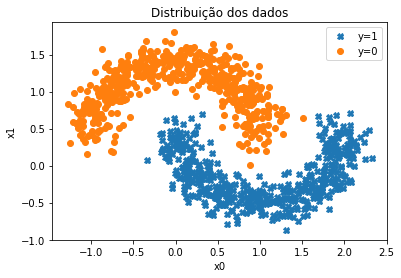

In [10]:
plt.plot(X[mask1, 0], X[mask1,1], 'X')
plt.plot(X[mask0, 0], X[mask0, 1], 'o')
plt.xlabel('x0'), plt.ylabel('x1')
plt.title("Distribuição dos dados")
plt.legend(['y=1', 'y=0'])
plt.savefig(os.path.join(image_dir, 'data.png'), bbox_inches='tight')
plt.show()

A distribuição de dados acima não pode ser completamente separada por modelos lineares (não há hiperplano que separe completamente os dados das duas classes). Entretanto não há grande mistura entre os elementos de cada classe, o que indica que provavelmente existem modelos capazes de separar os dados com uma taxa de erro nula, ou muito pequena.

## Discriminante linear de Fischer (LDA)

In [11]:
y_hat = lambda w, X: np.dot(X, w)

In [12]:
Sw = np.zeros((2,2))
mu1 = np.mean(X[mask1], 0)
mu0 = np.mean(X[mask0], 0)

for i in mask0:
    Sw += np.dot((X[i].reshape((2,1)) - mu0.reshape((1,2))),((X[i].reshape((2,1)) - mu0.reshape((1,2)))).T)
for i in mask1:
    Sw += np.dot((X[i].reshape((2,1)) - mu1.reshape((1,2))),((X[i].reshape((2,1)) - mu1.reshape((1,2)))).T)
Sw

array([[ 2.23939149e+03, -5.36498142e-02],
       [-5.36498142e-02,  1.43394973e+03]])

In [13]:
Sb = np.dot((mu1 - mu0),(mu1 - mu0).T)
Sb

2.4003468221575144

In [14]:
J = lambda w: np.dot(np.dot(w.T, Sb), w)/np.dot(np.dot(w.T, Sw), w)

In [15]:
w = np.dot(np.linalg.inv(Sw),(mu1 - mu0))
w = w/np.linalg.norm(w)
w

array([ 0.48042956, -0.87703332])

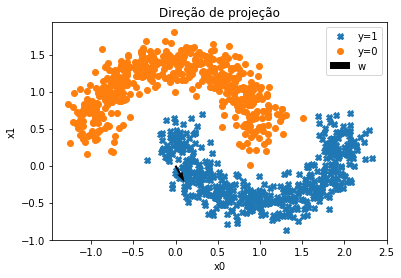

In [16]:
plt.plot(X[mask1, 0], X[mask1,1], 'X', zorder=1)
plt.plot(X[mask0, 0], X[mask0, 1], 'o', zorder=2)


origin = [0], [0] # origin point
plt.xlabel('x0'), plt.ylabel('x1')
plt.title("Direção de projeção")
plt.quiver(*origin, w[0], w[1], width=0.006, color='black', zorder=3)

plt.legend(['y=1', 'y=0', 'w'])
plt.savefig(os.path.join(image_dir, 'proj.png'), bbox_inches='tight')
plt.show()

### Projeção em w

In [17]:
mu = np.array([np.average(X[:,0]), np.average(X[:,1])])
delta = np.array([(np.max(X[:,0]) - np.min(X[:,0])), (np.max(X[:,1]) - np.min(X[:,1]))])

X = (X - np.ones([X.shape[0],1])*mu)*(np.ones([X.shape[0],1])*(1/delta))

In [18]:
lda = lambda X, w: np.dot(X, w)

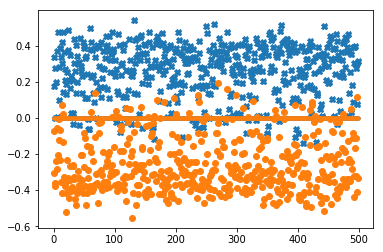

In [19]:
out = lda(X, w)
plt.stem(out[mask1], basefmt='.', linefmt='C0.', markerfmt='C0X')
plt.stem(out[mask0], basefmt='.', linefmt='C1.', markerfmt='C1o')
plt.savefig(os.path.join(image_dir, 'stem_proj.png'), bbox_inches='tight')
plt.show()

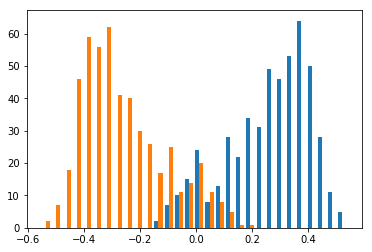

In [20]:
plt.hist([out[mask1], out[mask0]], bins=30, color=['C0', 'C1'])
plt.savefig(os.path.join(image_dir, 'hist.png'), bbox_inches='tight')
plt.show()

Como previsto, os dados não podem ser totalmente separados. Na direção projetada, há uma mistura dos dados entre os valores -0.2, 0.2, mas a maior parte dos dados se encontra fora desta região de intersecção.

### Curva ROC

In [21]:
def decision(X, w, thres, model):
    out = model(X, w)
    return np.array([1 if e > thres else 0 for e in out])

In [22]:
def confusion(out, y):
    tp = fp = tn = fn = 0
    for i, e in enumerate(out):
        if e:
            if y[i]:
                tp += 1
            else:
                fp += 1
        else:
            if y[i]:
                fn += 1
            else:
                tn += 1
    return tp, fp, fn, tn

In [23]:
def roc_curve(X, y, w, thres_v, model):
    roc = []
    f1_v = []
    for t in thres_v:
        out = decision(X, w, t, model)
        tp, fp, fn, tn = confusion(out, y)
        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        f1 = 2*tp/(2*tp + fn + fp)
        f1_v.append([t, f1])
        roc.append([fpr, tpr])
    return np.array(roc), np.array(f1_v)

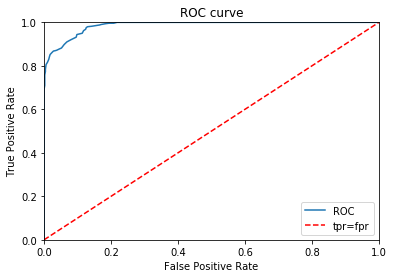

In [24]:
thres_v = [0.01*e for e in range(-200, 201)]
roc, f1 = roc_curve(X, y, w, thres_v, lda)
plt.plot(roc[:,0], roc[:,1], 'C0-')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC curve")
plt.legend(["ROC", "tpr=fpr"])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(os.path.join(image_dir, 'roc.png'), bbox_inches='tight')
plt.show()

### F1 score

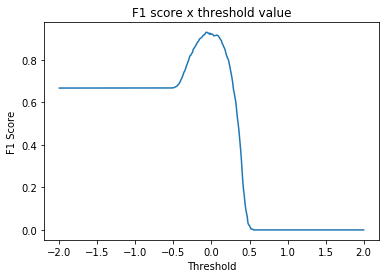

Threshold with highest f1-score: -0.07, (0.9289)


In [25]:
plt.plot(f1[:,0], f1[:,1], 'C0-')
plt.title("F1 score x threshold value")
plt.ylabel('F1 Score')
plt.xlabel('Threshold')
plt.savefig(os.path.join(image_dir, 'f1.png'), bbox_inches='tight')
plt.show()
print("Threshold with highest f1-score: {}, ({:.4f})".format(f1[np.argmax(f1[:,1]), 0], f1[np.argmax(f1[:,1]), 1]))

Podemos perceber que para valores do threshold bastante próximos de zero o modelo tem a melhor f1-medida, com o valor ótimo sendo threshold de -0.07 (f1-medida de 0.9289). 

## Regressão Logística

In [26]:
g = lambda z: 1/(1 + np.exp(-z))

In [27]:
lr = lambda Phi, w: g(np.dot(Phi, w))

In [28]:
mmq = lambda Phi, y: np.dot(np.dot(np.linalg.inv(np.dot(Phi.T, Phi)), Phi.T), y)

In [29]:
w = mmq(Phi, y)

In [30]:
def J(y_hat, y):
    J = 0
    for e, f in zip(y, y_hat):
        J += e*np.log10(f) + (1-e)*np.log10(1-f)
    return (-J/y.shape[0])[0]

In [31]:
def gradient_descent_step(Phi, y_hat, y, w, alpha):
    grad = -np.dot((y - y_hat).T, Phi)/y_hat.shape[0]
    grad = np.sum(grad, 0)/y_hat.shape[0]
    grad = grad.reshape((grad.shape[0], 1))
    return w - alpha*grad

In [32]:
def gradient_descent(Phi, y, w, alpha, epochs, early_stop_param, v=0):
    epoch = count = 0
    min_error = 999
    while epoch < epochs and count < early_stop_param:
        y_hat = lr(Phi, w)
        error = J(y_hat, y)
        w = gradient_descent_step(Phi, y_hat, y, w, alpha)
        if error < min_error:
            min_error = error
            count = 0
        else:
            count += 1
        if v:
            print('.', end='')
        epoch += 1
    
    return w

In [33]:
w = 0.1*np.random.random([3])
w = w.reshape((w.shape[0], 1))

In [34]:
w = gradient_descent(Phi, y, w, 5, 5000, 10, 1)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [35]:
w

array([[ 0.3682868 ],
       [ 1.18698953],
       [-2.53999012]])

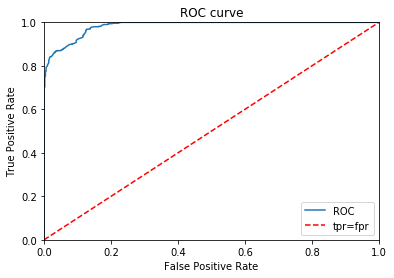

In [36]:
thres_v = [0.001*e for e in range(0,1001, 5)]
roc, f1 = roc_curve(Phi, y, w, thres_v, lr)
plt.plot(roc[:,0], roc[:,1], 'C0-')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC curve")
plt.legend(["ROC", "tpr=fpr"])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(os.path.join(image_dir, 'roc_lr.png'), bbox_inches='tight')
plt.show()

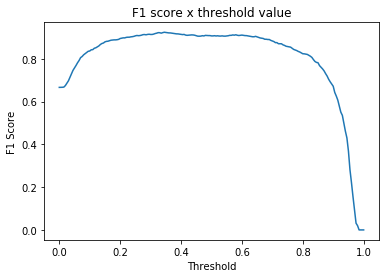

Threshold with highest f1-score: 0.3450, (0.9245)


In [37]:
plt.plot(f1[:,0], f1[:,1], 'C0-')
plt.title("F1 score x threshold value")
plt.ylabel('F1 Score')
plt.xlabel('Threshold')
plt.savefig(os.path.join(image_dir, 'f1_lr.png'), bbox_inches='tight')
plt.show()
print("Threshold with highest f1-score: {:.4f}, ({:.4f})".format(f1[np.argmax(f1[:,1]), 0], f1[np.argmax(f1[:,1]), 1]))

Podemos perceber que em comparação com o LDA, o modelo de regressão logística possue uma quantidade bem maior de valores de threshold com valores semelhantes de f1-medida, com o valor ótimo sendo threshold de 0.345 (f1-medida de 0.9245). Isto provavelmente se da por conta da função sigmoidal que acaba por concentrar os dados nas extremidades (perto de 0 ou 1) por seu formato (crescimento rápido em torno de 0.5 e saturação em 0 e 1).

Ambos os modelos obtiveram valores próximos para a f1-medida, dado que o modelo LDA tem solução fechada (exige menor capacidade computacional), ele parece ser uma boa opção de modelo para a resolução deste problema.

# 2 - Classificação multi-classe

## Download dataset

In [38]:
data_url = 'http://www.dca.fee.unicamp.br/~lboccato/dataset_vehicle.csv'
data_path = os.path.join(data_dir, 'dataset_vehicle.csv')

urllib.request.urlretrieve(data_url, data_path)

('/home/rafael/inbox/machine-learning/2-linear-classification-and-knn/data/dataset_vehicle.csv',
 <http.client.HTTPMessage at 0x7f3d1b71bba8>)

In [39]:
%%bash
head "../data/dataset_vehicle.csv"

"COMPACTNESS","CIRCULARITY","DISTANCE_CIRCULARITY","RADIUS_RATIO","PR.AXIS_ASPECT_RATIO","MAX.LENGTH_ASPECT_RATIO","SCATTER_RATIO","ELONGATEDNESS","PR.AXIS_RECTANGULARITY","MAX.LENGTH_RECTANGULARITY","SCALED_VARIANCE_MAJOR","SCALED_VARIANCE_MINOR","SCALED_RADIUS_OF_GYRATION","SKEWNESS_ABOUT_MAJOR","SKEWNESS_ABOUT_MINOR","KURTOSIS_ABOUT_MAJOR","KURTOSIS_ABOUT_MINOR","HOLLOWS_RATIO","Class"
95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus
107,57,106,172,50,6,255,26,28,169,280,957,264,85,5,9,181,183,bus
97,43,73,173,65,6,153,42,19,143,176,361,172,66,13,1,200,204,bus
90,43,66,157,65,9,137,48,18,146,162,281,164,67,3,3,193,202,van
86,34,62,140,61,7,122,54,17,127,141,223,112,64,2,14,200,208,van


## Importa dataset

In [40]:
X = np.loadtxt(data_path, skiprows=1, usecols=range(18), delimiter=',')
X.shape

(846, 18)

In [41]:
y = []
with open(data_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        y.append(row['Class'])   
len(y)

846

In [42]:
classes = list(set(y))
classes

['van', 'saab', 'opel', 'bus']

In [43]:
Y = np.zeros((len(y), len(classes)))
for i, e in enumerate(y):
    if e == classes[0]:
        Y[i,0] = 1
    elif e == classes[1]:
        Y[i,1] = 1
    elif e == classes[2]:
        Y[i,2] = 1
    else:
        Y[i,3] = 1
Y.shape

(846, 4)

In [44]:
holdout_n = int(0.3*len(y))

In [45]:
mu = np.array([np.average(X[:,i]) for i in range(X.shape[1])])
delta = np.array([(np.max(X[:,i]) - np.min(X[:,i])) for i in range(X.shape[1])])

X = (X - np.ones([X.shape[0],1])*mu)*(np.ones([X.shape[0],1])*(1/delta))

In [46]:
X_test = X[:holdout_n, :]
X_train = X[holdout_n:,:]
Y_test = Y[:holdout_n, :]
Y_train = Y[holdout_n:,:]
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((593, 18), (253, 18), (593, 4), (253, 4))

In [47]:
Phi_train = np.column_stack((np.ones(X_train.shape[0]), X_train))
Phi_test = np.column_stack((np.ones(X_test.shape[0]), X_test))

## Regressão Logística

In [48]:
Q = len(classes)
W = 0.01*np.random.random(((Q*(Q-1))//2, Phi_test.shape[1]))
W.shape

(6, 19)

In [49]:
k = 0
mask = [[]]*W.shape[0]
aux = []
for i in range(Q-1):
    for j in range(i+1, Q):
        mask[k] = [l for l, (e, f) in enumerate(zip(Y_train[:,i],Y_train[:,j])) if (e or f)]
        k += 1
        aux.append((i, j))

In [50]:
for i, m in enumerate(mask):
    w = W[i].reshape((W.shape[1], 1))
    y = Y_train[m,aux[i][0]].reshape((Y_train[m].shape[0], 1))
    X = Phi_train[m,:]
    grad = gradient_descent(X, y, w, 1000, 5000, 5)[:,0]
    W[i] = grad[:]

In [51]:
def one_vs_one(Phi, W):
    votes = np.zeros((Phi.shape[0], 4))
    ans = []

    for i, a in enumerate(aux):
        w = W[i].reshape((W.shape[1], 1))
        X = Phi
        y = lr(X, w)
        for j, e in enumerate(y):
            votes[j, a[0]] += e
            votes[j, a[1]] += 1-e
    for e in votes:
        #print(e)
        ans.append(np.argmax(e))
    return ans

In [52]:
y_hat = one_vs_one(Phi_test, W)

In [53]:
Y_hat = np.zeros((len(y), len(classes)))
for i, e in enumerate(y):
    if e == classes[0]:
        Y_hat[i,0] = 1
    elif e == classes[1]:
        Y_hat[i,1] = 1
    elif e == classes[2]:
        Y_hat[i,2] = 1
    else:
        Y_hat[i,3] = 1

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [54]:
y_test = np.argmax(Y_test, 1)
np.sum((y_test == np.array(y_hat)))/y_test.shape[0]

0.8023715415019763

In [55]:
def confusion(y_hat, y, n_classes):
    ans = np.zeros((n_classes, n_classes))
    for i, (e, f) in enumerate(zip(y, y_hat)):
        ans[int(e)][int(f)] += 1
    return ans

In [56]:
print(classes)
cm = confusion(y_hat, y_test, len(classes))

['van', 'saab', 'opel', 'bus']


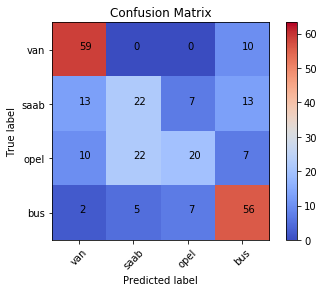

Average accuracy: 0.6206


In [80]:
N = len(y_test)/4
cax = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.coolwarm, vmin=0, vmax=N)
classNames = classes
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
for i, e in enumerate(cm):
    for j, f in enumerate(e):
        plt.text(j,i, str(int(cm[i][j])))
plt.colorbar(cax)
plt.show()
print("Average accuracy: {:.4f}".format(np.sum(np.diag(cm))/np.sum(cm)))

Como esperado, o modelo consegue classificar muito melhor os exemplos das classes 'van' e 'bus', pois provavelmente as características de entrada são mais discrepantes do que entre 'opel' e 'saab' (silhoueta de ônibus e van são mais únicas do que de do Opel e Saab). 

## K-nearest Neighbours

In [58]:
d = lambda x, y, p: np.power(np.linalg.norm((x-y), p), 1./p)

In [59]:
def neighboors(x, X, k):
    dist = []
    for i, e in enumerate(X):
        dist.append(d(x, e, 2))
    dist = np.array(dist)
    ans = [[e, f] for e, f in zip(np.argsort(dist), np.sort(dist))]
    return ans[:k]

In [60]:
def knn(X_train, Y_train, x, k):
    X_prime = neighboors(x, X_train, k)
    mask = [n[0] for n in X_prime]
    classes = np.sum(Y_train[mask], 0)
    return np.argmax(classes)

In [61]:
def knn_predict(X_train, Y_train, X_test, k):
    y_test = np.empty(X_test.shape[0])
    for i, x in enumerate(X_test):
        y_test[i] =  knn(X_train, Y_train, x, k)
    return y_test

In [68]:
y_hat = knn_predict(X_train, Y_train, X_test, 5)

In [69]:
y_test = np.argmax(Y_test, 1)
np.sum((y_test == np.array(y_hat)))/y_test.shape[0]

0.7351778656126482

In [70]:
avg_acc = np.sum(cm, 0)

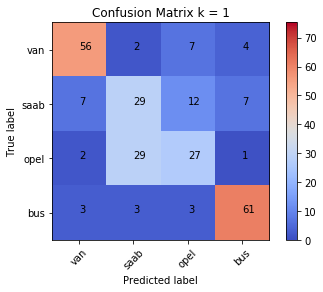

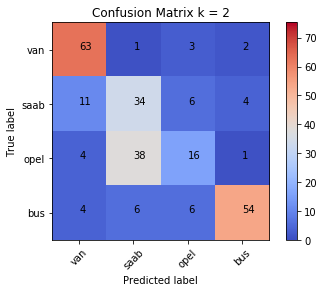

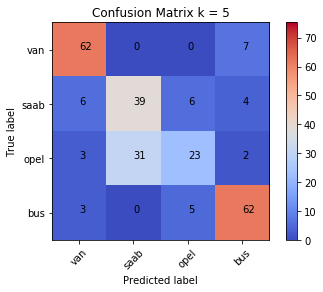

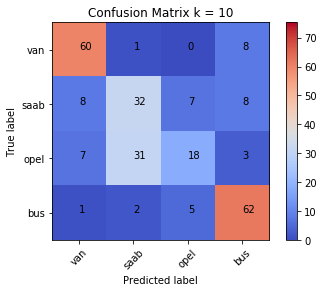

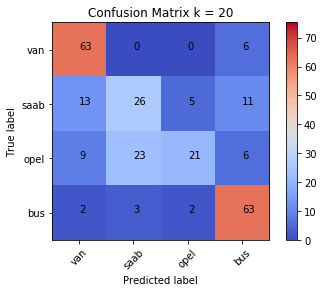

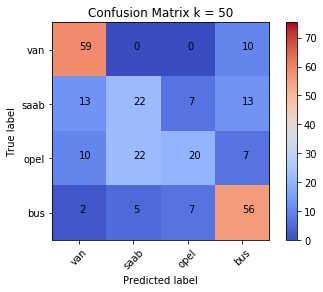

In [71]:
for k in [1, 2, 5, 10, 20, 50]:
    y_hat = knn_predict(X_train, Y_train, X_test, k)
    cm = confusion(y_hat, y_test, len(classes))
    N = len(y)/4
    cax = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.coolwarm, vmin=0, vmax=N)
    classNames = classes
    plt.title('Confusion Matrix k = '+str(k))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    for i, e in enumerate(cm):
        for j, f in enumerate(e):
            plt.text(j,i, str(int(cm[i][j])))
    plt.colorbar(cax)
    plt.show()